*Tujuan dari data analytics kami adalah untuk menebak harga dari sebuah flight price dengan dataset yang sudah tertera.* 

**IMPORTING LIBRARIES**

# Importing Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Data Gathering


In [2]:
!wget https://raw.githubusercontent.com/Tio6536/BigData/main/Clean_Dataset.csv

--2022-06-16 13:16:16--  https://raw.githubusercontent.com/Tio6536/BigData/main/Clean_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24683279 (24M) [text/plain]
Saving to: ‘Clean_Dataset.csv’

Clean_Dataset.csv   100%[===================>]  23.54M   150MB/s    in 0.2s    

2022-06-16 13:16:16 (150 MB/s) - ‘Clean_Dataset.csv’ saved [24683279/24683279]



# Mengubah data menjadi dataframe

In [3]:
df = pd.read_csv("Clean_Dataset.csv")

In [4]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [5]:
df.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

**Menghapus kolom 'Unnamed: 0' karena tidak mempunyai relevansi data dengan tujuan dari data analytics yang ada.**

Note: 'Unnamed: 0' merupakan sebuah index dari setiap kolom yang ada

In [6]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [7]:
vari = df.copy(deep=True)

Membuat variabel baru untuk mengubah data yang ada di dalam dataset

# Menghapus data/kolom yang tidak relevan dengan tujuan data analisis

In [8]:
vari

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


# Menampilkan data dan melihat korelasi antara satu data dengan yang lain

In [9]:
vari.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


## 1. Apakah harga berbeda dengan perusaahan airline yang dipilih?


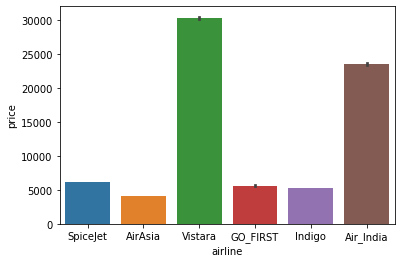

In [10]:
sns.barplot(x="airline",y="price",data=vari)

Berikut merupakan rata-rata dari harga setiap ticket untuk airline yang berbeda-beda. Tetapi muncul pertanyaan baru. Seberapa jauh harga ekonomi dengan bisnis untuk setiap airline? 


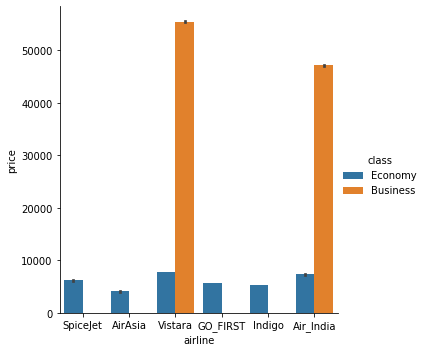

In [11]:
sns.catplot(data=vari, x="airline",y="price", hue="class",kind="bar")

Berikut merupakan data untuk setiap harga dengan kelas ekonomi maupun bisnis.Dapat dilihat dari tipe airline yang dipilih bahwa itu juga mempengaruhi data yang ada dengan Vistara mempunyai harga yang tertinggi di bagian Business Class. Untuk harga termurah, AirAsia menduduki harga termurah di Economy Class. 

## 2. Bagaimana harga dipengaruhi oleh booking dengan departur penerbangan?

In [12]:
vari.loc[(vari['days_left']>=1) & (vari['days_left']<=10),'days_left']=0
vari.loc[(vari['days_left']>=11) & (vari['days_left']<=20),'days_left']=1
vari.loc[(vari['days_left']>=21) & (vari['days_left']<=30),'days_left']=2
vari.loc[(vari['days_left']>=31) & (vari['days_left']<=40),'days_left']=3
vari.loc[(vari['days_left']>=41) & (vari['days_left']<=49),'days_left']=4

Mengkelompokkan data menjadi beberapa bagian:

    0 = 1-10 hari jarak antara pemesanan dengan penerbangan
    1 = 11 - 20 hari jarak antara pemesanan dengan penerbangan
    2 = 21 - 30 hari jarak antara pemesanan dengan penerbangan
    3 = 31 - 40 hari jarak antara pemesanan dengan penerbangan
    4 = 41 - 49 hari jarak antara pemesanan dengan penerbangan

In [13]:
vari.days_left.unique()

array([0, 1, 2, 3, 4])

In [14]:
vari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


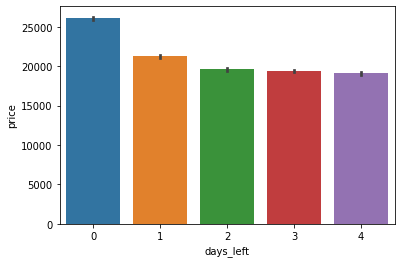

In [15]:
sns.barplot(x="days_left",y="price",data=vari)

Bisa dilihat jika jarak pemesanan dengan penerbangan lebih pendek (dalam hari), maka harga tiket akan lebih mahal dibandingkan dengan jadwal penerbangan yang jauh dari tanggal pemesanan tiket (maks: 40-49 hari). 

In [16]:
top10=pd.DataFrame(data=df['days_left'].value_counts().head(10))
top10.reset_index(inplace=True)
top10.columns=['days_left','Occurence']

In [17]:
top10

,days_left,Occurence
0,25,6633
1,18,6602
2,39,6593
3,32,6585
4,26,6573
5,24,6542
6,19,6537
7,31,6534
8,33,6532
9,40,6531


Bisa dilihat juga bahwa rata-rata user memesan tiket 15 hari keatas sebelum jadwal penerbangan

## 3. Apakah banyaknya pemberhentian pada setiap penerbangan mempengaruhi harga tiket?


Pertama kita melihat frekuensi pemberhentian seberapa sering. Berikut disediakan dalam bentuk pie chart

In [18]:
stops =pd.DataFrame(data=vari['stops'].value_counts())
stops.reset_index(inplace=True)
stops.columns=['Number of Stops','Occurence']

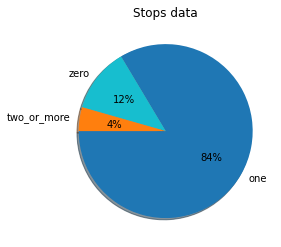

In [19]:
fig, ax = plt.subplots()
ax.pie(stops['Occurence'], labels = stops['Number of Stops'],
          colors = ['tab:blue', 'tab:cyan','tab:orange'],
          autopct='%.0f%%',
          shadow = True,
          startangle = 180)

ax.set_title('Stops data')
plt.show()

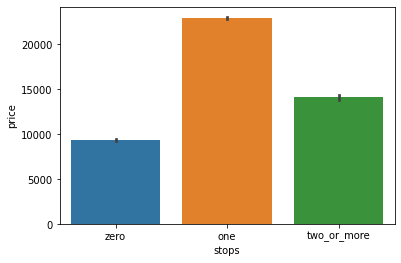

In [20]:
sns.barplot(x="stops",y="price",data=vari)

Dapat dilihat bahwa penerbangan yang tidak memiliki pemberhentian memiliki harga paling murah. Akan tetapi penerbangan yang memiliki 1 pemberhentian lebih mahal dari penerbangan dengan 2 pemberhentian atau lebih. Secara logika, seharusnya penerbangan dengan 2 pemberhentian atau lebih seharusnya memiliki rata-rata harga yang lebih mahal daripada 1 pemberhentian. Oleh karena itu, data 'stops' sekarang dibagi menjadi beberapa bagian dan dikelompokkan dari jenis penerbangan yang ada.

[Text(0.5, 1.0, 'Variasi harga berdasarkan stop dari setiap airline')]

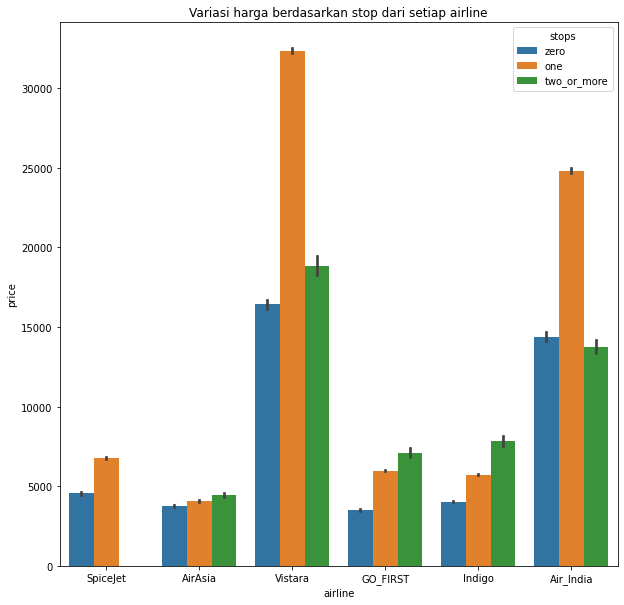

In [21]:
plt.figure(figsize=(10, 10))
sns.barplot(x='airline',y='price',hue='stops',data=vari).set(title='Variasi harga berdasarkan stop dari setiap airline')

Dari grafik tersebut dapat dilihat bahwa Vistara dan Air_India memiliki pemberhentian 0,1, maupun 2 atau lebih dengan harga tertinggi di dalam chartnya. Akan tetapi harga rata-rata Vistara dan Air_India pada 1 pemberhentian lebih besar daripada 2 pemberhentian atau lebih. Hal ini disebabkan oleh cost efficiency dari sebuah bahan bakar pesawat yang ada. Jika pesawat mempunyai pemberhentian yang banyak maka harga nya kemungkinan akan lebih murah daripada pesawat yang tidak memiliki pemberhentian dengan tujuan yang sama. Hal ini juga ditentukan oleh jarak yang ditempuh oleh pesawat. 

## 4. Apakah harga dari tiket dipengaruhi oleh waktu departur dan sampai?

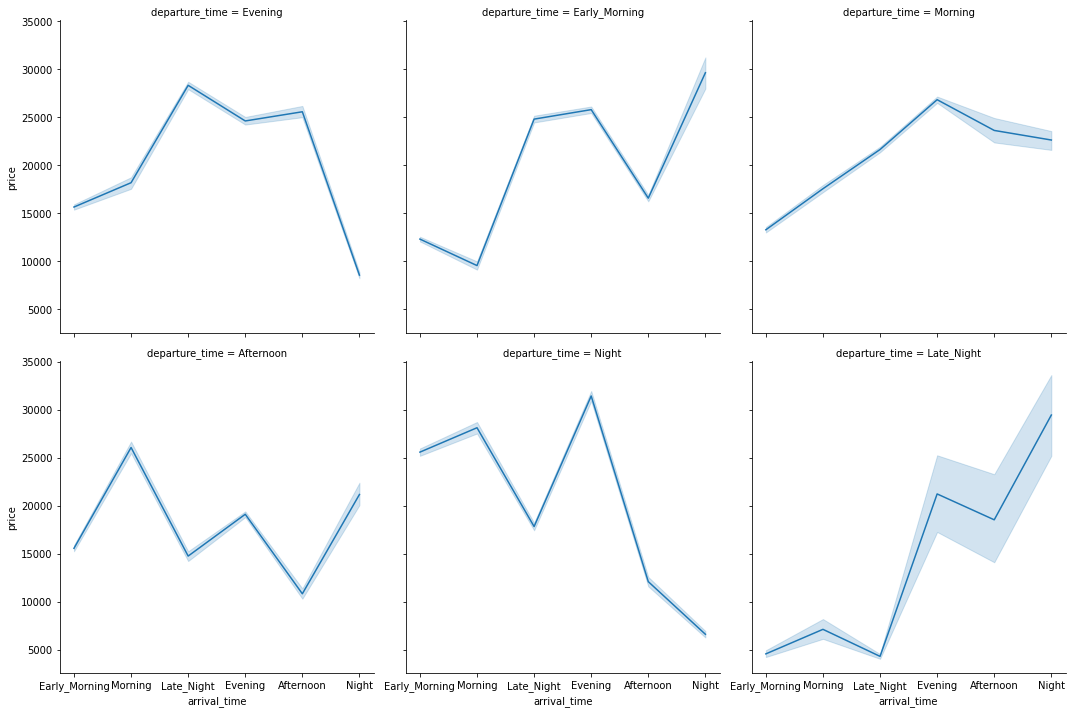

In [22]:
sns.relplot(data=df,kind="line",col="departure_time",x="arrival_time",y="price",col_wrap=3)

Kita dapat menemukan beberapa pola untuk perubahan harga berdasarkan jam keberangkatan pesawat dan sampainya pesawat. Pola yang ditemukan adalah untuk harga termurah sebagai berikut:
1. Evening -> Night
2. Early_Morning -> Morning
3. Morning -> Early_Morning
4. Afternoon -> Afternoon
5. Night -> Night
6. Late_Night -> Late_Night 

##5. Apakah durasi dari sebuah penerbangan mempengaruhi harga tiket?

In [23]:
timeMin = df.copy(deep=True)

Mengkelompokkan data duration

In [24]:
timeMin.loc[(timeMin['duration']>=0) & (timeMin['duration']<=10),'duration']=0
timeMin.loc[(timeMin['duration']>=10) & (timeMin['duration']<=20),'duration']=1
timeMin.loc[(timeMin['duration']>=20) & (timeMin['duration']<=30),'duration']=2
timeMin.loc[(timeMin['duration']>=30) & (timeMin['duration']<=40),'duration']=3
timeMin.loc[(timeMin['duration']>=40) & (timeMin['duration']<=50),'duration']=4

*   1-10 Jam = 0
*   10-20 Jam = 1 
*   20-30 Jam = 2
*   30-40 Jam = 3
*   40-50 Jam = 4

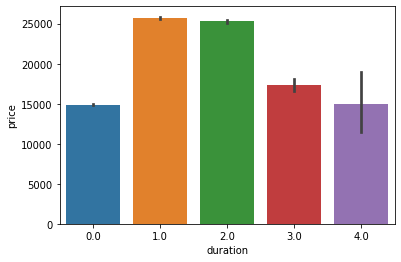

In [25]:
sns.barplot(x="duration",y="price",data=timeMin)

Ditemukan bahwa durasi penerbangan 10-20 jam dan 20-30 jam memiliki harga tiket paling mahal sedangkan tiket dengan harga paling murah diduduki oleh penerbangan dengan durasi 0-10 Jam.

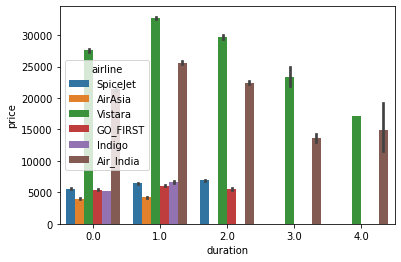

In [26]:
sns.barplot(x="duration",y="price",data=timeMin,hue="airline")

Dari grafik tersebut kita juga dapat menemukan flight yang merangkup semua jam penerbangan adalah Vistara dan Air_India dan memiliki harga termahal diantara yang lain

## 6. Apakah asal kota dan destinasi penerbangan akan mempengaruhi harga penerbangan?

<Figure size 1440x1440 with 0 Axes>

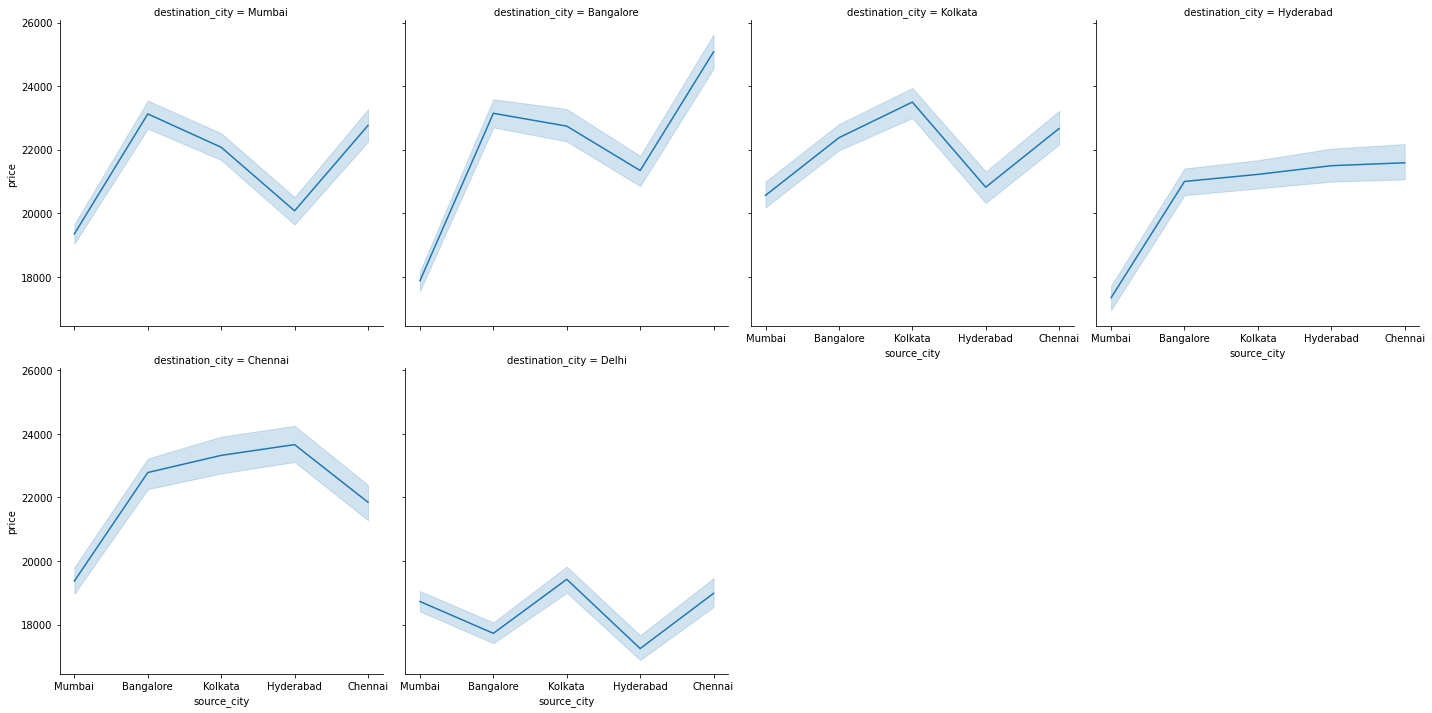

In [27]:
plt.figure(figsize=(20,20))
sns.relplot(data=df,kind="line",col="destination_city",x="source_city",y="price",col_wrap=4)

Dapat dilihat bahwa tujuan dan asal kota mempengaruhi data dari harga tiket penerbangan. Dari data diatas kita dapat menyimpulkan:
  *   Chennai -> Bangalore = Tiket termahal
  *   Mumbai -> Hyderbad = Tiket termurah
  



# Predictive Analysis


In [28]:
Label=LabelEncoder()

In [29]:
vari2 =df.copy(deep=True)

In [30]:
vari2['source_city']=Label.fit_transform(vari2['source_city'])
vari2['destination_city']=Label.fit_transform(vari2['destination_city'])
vari2['departure_time']=Label.fit_transform(vari2['departure_time'])
vari2['arrival_time']=Label.fit_transform(vari2['arrival_time'])
vari2['class']=Label.fit_transform(vari2['class'])
vari2['stops']=Label.fit_transform(vari2['stops'])
vari2['airline']=Label.fit_transform(vari['airline'])

Mengubah data menjadi numerik untuk dapat diproses oleh model

Membuang kolom flight karena tidak ada relevansi data

In [31]:
vari2.drop("flight", axis=1, inplace=True)

In [32]:
targetvar2 = vari2.drop('price',axis=1)

In [33]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(targetvar2, vari2['price'], test_size=0.2, random_state=42)

In [34]:
modelxgb=xgb.XGBRegressor(objective = 'reg:squarederror',learning_rate=0.01,max_depth=5,n_estimators=150)

In [35]:
modelxgb.fit(X_train_2,y_train_2)

XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=150,
             objective='reg:squarederror')

In [36]:
resultxgbtrain=modelxgb.score(X_train_2,y_train_2)

In [37]:
resultxgbtrain

0.8605474365369867

In [38]:
resultxgbtest=modelxgb.score(X_test_2,y_test_2)

In [39]:
resultxgbtest

0.8603815070891747

Dapat dilihat bahwa untuk bagian training memiliki score 0.8607 sedangkan untuk bagian testing memiliki akurasi 0.8603.

In [40]:
y_prediction_test_2=modelxgb.predict(X_test_2)

Membuat dataframe baru untuk membandingkan antar hasil asli dengan prediksi yang ada

In [41]:
dataBanding2 = pd.DataFrame()
dataBanding2['Real'] = y_test_2
dataBanding2['Predicted'] = y_prediction_test_2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


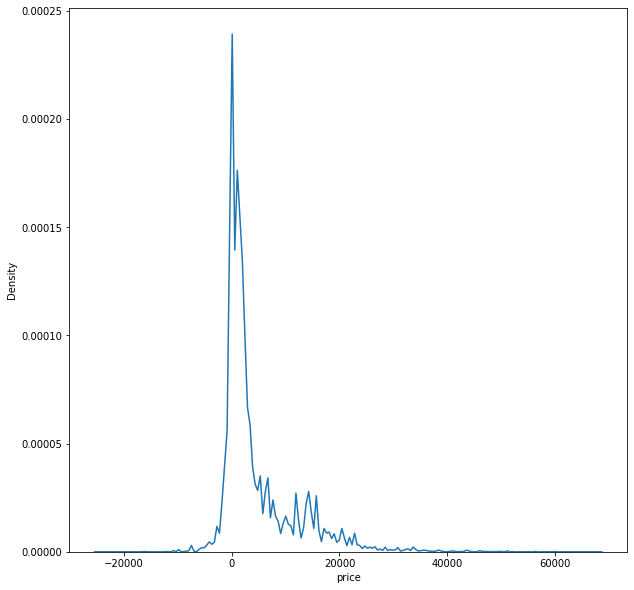

In [42]:
plt.figure(figsize = (10,10))
sns.kdeplot(y_test_2-y_prediction_test_2,bw=0.01)
plt.show()

Diatas merupakan grafik KDE (Kernel Density Estimation) dari hasil pengurangan antara hasil prediksi dengan hasil yang ada di dalam dataset. KDE sendiri menunjukkan semakin banyaknya data yang ada dalam sebuah kurva maka kurva tersebut akan meninggi. Dengan adanya KDE kita dapat melihat bahwa titik tertinggi pada kurva diatas memiliki ada di daerah dekat angka 0. Dari hal tersebut kita dapat menyimpulkan bahwa data paling banyak terdapat pada Hasil Data Awal - Hasil Data Prediksi memiliki hasil yang tidak jauh berbeda. Dengan begitu, kita dapat menyimpulkan bahwa model diatas dapat dibilang cukup akurat untuk menentukan harga tiket pesawat dengan rata-rata perbedaan antara hasil prediksi dengan data yang ada cukup minim. 

In [43]:
dataLiatHasil = pd.DataFrame()
dataLiatHasil['Diff'] = y_test_2-y_prediction_test_2

In [44]:
dataLiatHasil.describe()

,Diff
count,60031.000000
mean,4609.996063
std,7121.772205
min,-25281.871094
25%,289.897217
50%,1773.419434
75%,6639.968750
max,68523.089844


Kita juga dapat melihat bahwa rata-rata prediksi dari 60031 data yang ada memiliki perbedaan sebesar 4609

In [45]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.3 MB/s 


In [46]:
import shap

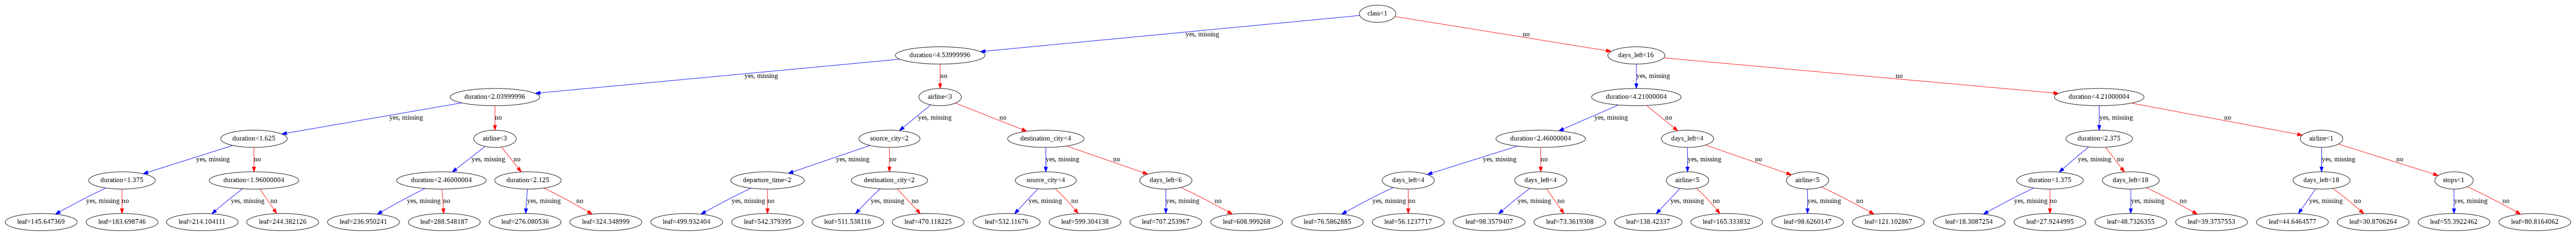

In [47]:
xgb.plot_tree(modelxgb)
plt.gcf().set_size_inches(100,100)
plt.show()

Berikut merupakan model tree yang sudah dibuat untuk memprediksi harga tiket penerbangan

In [48]:
explainingmodel=shap.Explainer(modelxgb)
valueshap=explainingmodel(X_test_2)

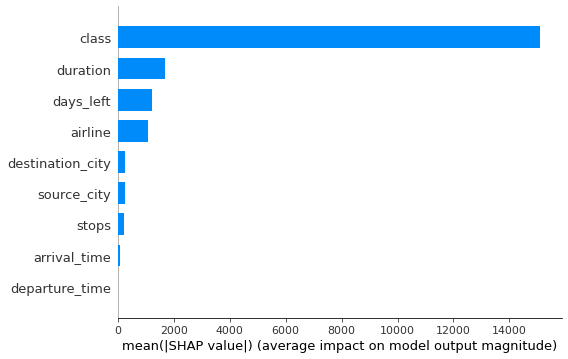

In [49]:
shap.summary_plot(valueshap,X_test_2,plot_type="bar")

Berikut merupakan faktor dan pengaruh dari setiap kelas terhadap harga tiket. Dapat dilihat bahwa pengaruh paling besar untuk penentuan harga tiket adalah kelas dari penerbangan (ekonomi, business). 

# Referensi



[1]
Yilmazkuday, D., & Yilmazkuday, H. (2014). The Role of Direct Flights in Trade Costs. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.2432355

[2]
Bashir, D., Montanez, G. D., Sehra, S., Segura, P. S., & Lauw, J. (2020). An Information-Theoretic Perspective on Overfitting and Underfitting. ArXiv.org. https://doi.org/10.48550/arXiv.2010.06076

‌
